<h1 style='text-align:center;font-size:5rem; color:#2FDD92;'>Forest Fire Detection</h1>

<h1 style='text-align:center; color:#FEE440;'>Using Deep Learning and Computer Vision</h1>

# Data Pre-Processing 

In [1]:
import os

folder_path = r'G:\My Drive\Personal Projects\Forest Fire Detection\Data\Train_Data\Fire'

num = 0
for file in os.listdir(folder_path):
#     if num%200 == 0:
#         print(f'Renamed {num} files...')
#     os.rename(folder_path+'\\'+file, folder_path+'\\'+'F_'+str(num)+'.jpg')
    num += 1

In [2]:
import cv2 # type: ignore
import numpy as np # type: ignore
import matplotlib.pyplot as plt # type: ignore

from tensorflow.keras.preprocessing.image import ImageDataGenerator # type: ignore

In [3]:
dataset = '../Data/Train_Data/'

def display(img,fire=None):
    
    img = cv2.cvtColor(img,cv2.COLOR_BGR2RGB)
    fig = plt.figure(figsize=(7,7))
    ax = fig.add_subplot(111)
    plt.title(fire)
    ax.imshow(img)

def display_gray(img):
    
    img = cv2.cvtColor(img,cv2.COLOR_BGR2GRAY)
    fig = plt.figure(figsize=(12,10))
    ax = fig.add_subplot(111)
    ax.imshow(img,cmap='gray')

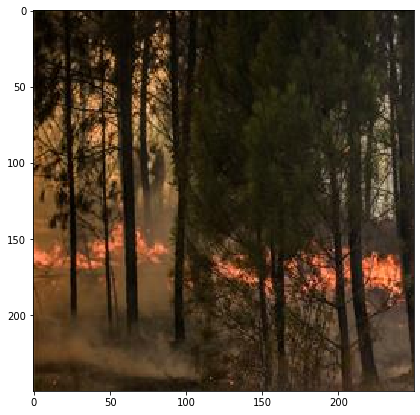

In [4]:
fire_img = cv2.imread(dataset+'Fire/F_18.jpg')
display(fire_img)

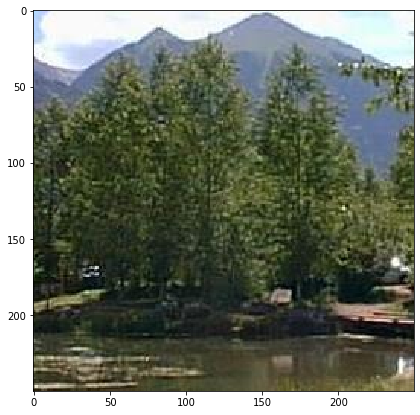

In [5]:
non_fire_img = cv2.imread(dataset+'Non_Fire/NF_12.jpg')
display(non_fire_img)

In [6]:
image_gen = ImageDataGenerator(rotation_range=30,
                              width_shift_range=0.1,
                              height_shift_range=0.1,
                              shear_range=0.2,
                              zoom_range=0.2,
                              rescale=1/255,
                              horizontal_flip=True,
                              fill_mode='nearest',
                              validation_split=0.2)

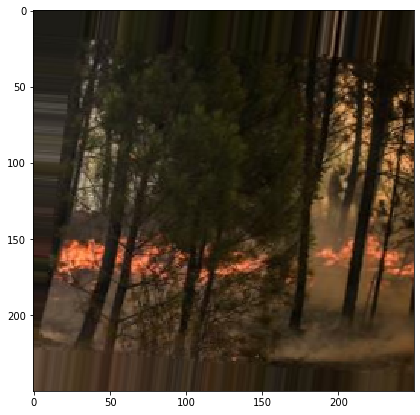

In [7]:
display(image_gen.random_transform(fire_img))

In [8]:
train_data_gen = image_gen.flow_from_directory(dataset,
                                           target_size=(250,250),
                                           batch_size=16,
                                           shuffle=True,
                                           class_mode='binary',
                                           subset='training')

Found 4000 images belonging to 2 classes.


In [9]:
validation_data_gen = image_gen.flow_from_directory(dataset,
                                           target_size=(250,250),
                                           batch_size=16,
                                           shuffle=True,
                                           class_mode='binary',
                                           subset='validation')

Found 1000 images belonging to 2 classes.


In [10]:
train_data_gen.class_indices

{'Fire': 0, 'Non_Fire': 1}

In [11]:
validation_data_gen.class_indices

{'Fire': 0, 'Non_Fire': 1}

In [12]:
len(train_data_gen.classes)

4000

# Building a Deep Learning Model

>#### We will be building a Convolutional Neural Network (CNN) for Image Classification 

In [13]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense,Conv2D,MaxPooling2D,Flatten,Dropout

In [14]:
model = Sequential()

model.add(Conv2D(filters=32,kernel_size=(3,3),input_shape=(250,250,3),activation='relu')) # Input layer
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(filters=64,kernel_size=(3,3),activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(filters=128,kernel_size=(3,3),activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(filters=256,kernel_size=(3,3),activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(filters=256,kernel_size=(3,3),activation='relu'))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Flatten())

model.add(Dense(128, activation='relu'))

model.add(Dropout(0.5))

model.add(Dense(1,activation='sigmoid')) # Output layer

model.compile(loss='binary_crossentropy', optimizer='adam', metrics=['accuracy'])

model.summary()

Model: "sequential"
_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d (Conv2D)              (None, 248, 248, 32)      896       
_________________________________________________________________
max_pooling2d (MaxPooling2D) (None, 124, 124, 32)      0         
_________________________________________________________________
conv2d_1 (Conv2D)            (None, 122, 122, 64)      18496     
_________________________________________________________________
max_pooling2d_1 (MaxPooling2 (None, 61, 61, 64)        0         
_________________________________________________________________
conv2d_2 (Conv2D)            (None, 59, 59, 128)       73856     
_________________________________________________________________
max_pooling2d_2 (MaxPooling2 (None, 29, 29, 128)       0         
_________________________________________________________________
conv2d_3 (Conv2D)            (None, 27, 27, 256)       2

# Fitting the model with Training Data

In [15]:
from tensorflow.keras.callbacks import ModelCheckpoint
checkpoint = ModelCheckpoint('../Models/ffd_model.h5',monitor='val_loss',mode='min',save_best_only=True)

cbs = [checkpoint]

In [16]:
#results = model.fit(train_data_gen,epochs=10,steps_per_epoch=100,validation_data=validation_data_gen,validation_steps=15,callbacks=cbs)

In [17]:
from tensorflow.keras.models import load_model

In [18]:
model = load_model('../Models/ffd_model.h5')

# Evaluating the model 

In [19]:
test_data_gen = image_gen.flow_from_directory('../Data/Test_Data/',target_size=(250,250),class_mode='binary')

Found 50 images belonging to 2 classes.


In [20]:
quality = model.evaluate(validation_data_gen)

63/63 [==============================] - 40s 629ms/step - loss: 0.1777 - accuracy: 0.9390


In [21]:
print('The accuracy of the model is {:.2f}%'.format(quality[1]*100))

The accuracy of the model is 93.90%


# Testing the Model 

In [22]:
import cv2
from tensorflow.keras.preprocessing import image
import numpy as np

In [23]:
def predict(img):

    i = cv2.imread(img)
    i = cv2.resize(i,(250,250))
    
    img = image.load_img(img,target_size=(250,250))
    img = image.img_to_array(img)
    img = np.expand_dims(img,axis=0)
    img = img / 255
    
    res = (model.predict(img) > 0.5).astype(np.int32)
    if res == 0:
        display(i,fire='FIRE DETECTED !')
    else:
        display(i,fire='No Fire Detected.')

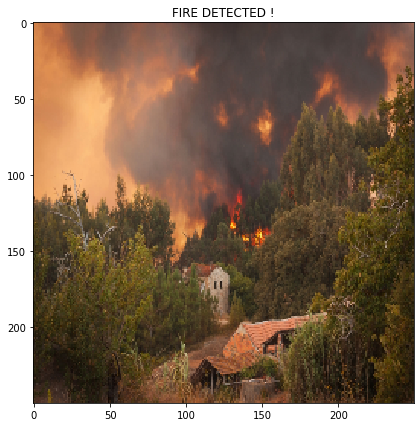

In [24]:
img = '../Data/Test_Data/Fire/F_20.jpg'
predict(img)

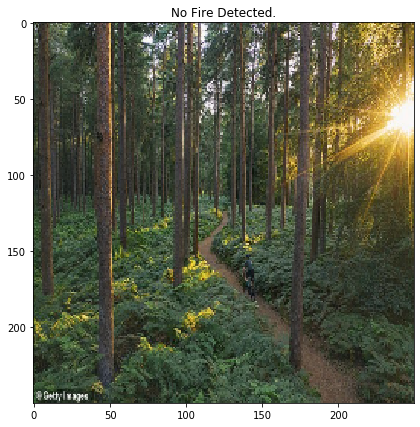

In [25]:
img = '../Data/Test_Data/Non_Fire/NF_9.jpg'
predict(img)